This notebook analyzes the dataset and its features. The dataset is mostly based on the housing market for Melbourne, Australia and has a variety of features that describe a house when it was sold on the market. The purpose of this analysis is to determine how well a Linear Regression model performs at predicting the price of a home.  

In [ ]:
# Data analysis libraries
import pandas as pd
import numpy as np

# Support Function
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV

# for evaulating predictions
from sklearn import metrics
import statistics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from feature_engine.imputation import RandomSampleImputer


# visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
housing = pd.read_csv("data/melb_data.csv")

## Feature Description

**Rooms**: Number of rooms

**Price**: Price in dollars

**Method**: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

**Type**: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

**SellerG**: Real Estate Agent

**Date**: Date sold

**Distance**: Distance from CBD

**Regionname**: General Region (West, North West, North, North east …etc)

**Propertycount**: Number of properties that exist in the suburb.

**Bedroom2** : Scraped # of Bedrooms (from different source)

**Bathroom**: Number of Bathrooms

**Car**: Number of carspots

**Landsize**: Land Size

**BuildingArea**: Building Size

**CouncilArea**: Governing council for the area

# Data Exploration

In [ ]:
housing.head()

In [ ]:
housing.tail()

#### Data Cleaning
We need to normalize the Date column so Pandas is able to understand

In [ ]:
housing[['Day','Month','Year']] = housing['Date'].str.split('/', expand=True)

housing['Date'] = housing['Month'] + '/' + housing['Day'] + '/' + housing['Year']

# overwriting the existing date
housing['Date'] = pd.to_datetime(housing['Date'])

# dropping the helping columns 
housing.drop(labels=['Day','Month', 'Year'], axis=1, inplace=True)

# creating some useful varible for our future analysis
housing['Month_name'] = housing['Date'].dt.month_name()

housing['day'] = housing['Date'].dt.day

housing['Year'] = housing['Date'].dt.year

In [ ]:
housing.head()

Finding correlations between Price and other features in the dataset.

In [ ]:
corr_matrix = housing.corr()
corr_matrix['Price'].sort_values(ascending=False)

Seems like the there is a positive correlation between the number of rooms and the price of a house. Lets look at further analysis.

##### No. of rooms year wise Vs Price


In [ ]:
sns.lmplot(data=housing, x='Rooms',y='Price', fit_reg=True, col='Year')
plt.show()

##### No. of Bedroom2 year wise Vs Price


In [ ]:
sns.lmplot(data=housing, x='Bedroom2',y='Price', fit_reg=True, col='Year')
plt.show()

##### No. of Bathroom year wise Vs Price


In [ ]:
sns.lmplot(data=housing, x='Bathroom',y='Price', fit_reg=True, col='Year')
plt.show()

In [ ]:
# to determine co-linearity, we evaluate the correlation of independent variables

# we calculate the correlations using pandas corr()
# and we round the values to 2 decimals
correlation_matrix = np.round(housing.corr(),2)

# plot the correlation matric using seaborn
# we use annot = true to print the correlation values

fig = plt.figure(figsize=(10,10))
sns.heatmap(data=correlation_matrix, annot=True)

### Rooms Vs. Bedroom2

Since rooms and Bedroom2 are both highly correlated to price, it would be best to choose between for training the model. For this model session I will choose to remove Bedroom2

# Feature Engineering

In [ ]:
# Some columns are not going to help our model, we will remove them. 
data = housing.drop(labels=['Address', 'Bedroom2', 'Date','Lattitude','Longtitude', 'YearBuilt', 'BuildingArea'],axis=1)

# Categorical Encoding

In [ ]:
# Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

In [ ]:
num_ohc_cols = (data[object_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))
num_ohc_cols.sum()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
housing_encoded = data.copy()
OH_encoder = OneHotEncoder()

new_df = None
for col in num_ohc_cols.index:
    OH_cols_train = OH_encoder.fit_transform(housing_encoded[[col]]).astype(int)
    
    # Remove categorical columns (will replace with one-hot encoding)
    housing_encoded = housing_encoded.drop(col, axis=1)

    cats = OH_encoder.categories_

    new_cols = ['_'.join([col, str(cat)]) for cat in cats[0]]

    new_df = pd.DataFrame(OH_cols_train.toarray(),
                            index=housing_encoded.index,
                            columns=new_cols)
    housing_encoded = pd.concat([housing_encoded, new_df], axis=1)


In [ ]:
X = housing_encoded.drop('Price', axis=1)
Y = housing_encoded['Price']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

In [ ]:
x_train.isnull().mean()


In [ ]:
x_test.isnull().mean()


#### Fixing Missing Values

In [ ]:
random_imputer = RandomSampleImputer(variables=['Car'])

random_imputer.fit(x_train)

In [ ]:
x_train = random_imputer.transform(x_train)
x_test = random_imputer.transform(x_test)

In [ ]:
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score"])

# Linear Regression Model

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(x_test)
mse = mean_squared_error(y_test, housing_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, housing_predictions)
r2 = r2_score(y_test, housing_predictions)
# print("MAE:",mae)
# print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print("R2 Score:", r2)
new_row = {"Model": "LinearRegression","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r2}
models = models.append(new_row, ignore_index=True)

# Polynomial Regression

In [ ]:
# Not able to run this with degree > 2 because it consumes too much memory.
degree = 1
poly_reg = PolynomialFeatures(degree, include_bias=False)

X_train_2d = poly_reg.fit_transform(x_train)
X_test_2d = poly_reg.transform(x_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_2d, y_train)
predictions = lin_reg.predict(X_test_2d)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# print("MAE:",mae)
# print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print("R2 Score:", r2)
new_row = {"Model": "Polynomial Regression","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r2}
models = models.append(new_row, ignore_index=True)


In [ ]:
ridge = Ridge()
ridge.fit(x_train, y_train)
predictions = ridge.predict(x_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# print("MAE:",mae)
# print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print("R2 Score:", r2)
new_row = {"Model": "Ridge Regression","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r2}
models = models.append(new_row, ignore_index=True)

In [ ]:
lasso = Lasso()
lasso.fit(x_train, y_train)
predictions = lasso.predict(x_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# print("MAE:",mae)
# print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print("R2 Score:", r2)
new_row = {"Model": "Lasso Regression","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r2}
models = models.append(new_row, ignore_index=True)

In [ ]:
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

ridgeCV = RidgeCV(alphas=alphas, cv=4).fit(x_train, y_train)

predictions = ridgeCV.predict(x_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# print("MAE:",mae)
# print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print("R2 Score:", r2)
new_row = {"Model": "Ridge CV","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r2}
models = models.append(new_row, ignore_index=True)

In [ ]:
alphas2 = np.array([0.005, 0.05, 0.1, 1, 5, 20, 50, 80, 100, 120, 140])

lassoCV = LassoCV(alphas=alphas2, max_iter=int(5e4), cv=4).fit(x_train, y_train)

predictions = lassoCV.predict(x_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# print("MAE:",mae)
# print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print("R2 Score:", r2)
new_row = {"Model": "Lasso CV","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r2}
models = models.append(new_row, ignore_index=True)

In [ ]:
l1_ratios = np.linspace(0.1, 0.9, 9)

elasticNetCV = ElasticNetCV(alphas=alphas2, l1_ratio=l1_ratios, max_iter=int(1e4)).fit(x_train, y_train)

predictions = elasticNetCV.predict(x_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# print("MAE:",mae)
# print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print("R2 Score:", r2)
new_row = {"Model": "Elastic Net CV","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r2}
models = models.append(new_row, ignore_index=True)

In [ ]:
models.sort_values(by="RMSE")

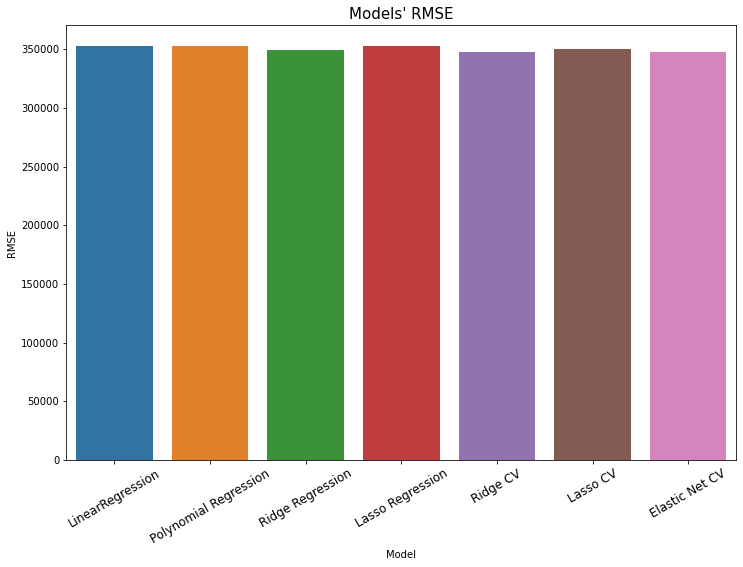

In [44]:
plt.figure(figsize=(12,8))
sns.barplot(x=models["Model"], y=models["RMSE"])
plt.title("Models' RMSE", size=15)
plt.xticks(rotation=30, size=12)
plt.show()

## Key Findings and Insights

Based on the comparison of regression models, Elastic Net CV seems to have the best results based on the RMSE. The RMSE for each model regression is still high. It would be better to either run another model to achieve better accuracy. It is worth noting that Lasso CV and Ridge CV also returned the lowest RMSE for our dataset. This makes sense provided that Elastic net combines L1 and L2 penalty functions. The polynomial regression is not valid because I was only able to run it with degree=1. When using degree > 1 the program could not allocate enough memory. I'm not sure why that was the case but it could be investigated some more.

Credit to https://www.kaggle.com/code/nishathakkar/melbourne-housing-price-eda-and-rf-model#Feature-Engineering for providing a framework on how to approach this dataset.